In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [ ]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input,
# convert them into normal distribution and pass them to the decoder layer

class Sampling(layers.Layer):
	"""Uses (mean, log_var) to sample z, the vector encoding a digit."""

	def call(self, inputs):
		mean, log_var = inputs
		batch = tf.shape(mean)[0]
		dim = tf.shape(mean)[1]
		epsilon = tf.random.normal(shape=(batch, dim))
		return mean + tf.exp(0.5 * log_var) * epsilon


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │        100,368 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super().__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder
		self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
		self.reconstruction_loss_tracker = keras.metrics.Mean(
			name="reconstruction_loss"
		)
		self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

	@property
	def metrics(self):
		return [
			self.total_loss_tracker,
			self.reconstruction_loss_tracker,
			self.kl_loss_tracker,
		]

	def train_step(self, data):
		with tf.GradientTape() as tape:
			mean,log_var, z = self.encoder(data)
			reconstruction = self.decoder(z)
			reconstruction_loss = tf.reduce_mean(
				tf.reduce_sum(
					keras.losses.binary_crossentropy(data, reconstruction),
					axis=(1, 2),
				)
			)
			kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
			kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		self.total_loss_tracker.update_state(total_loss)
		self.reconstruction_loss_tracker.update_state(reconstruction_loss)
		self.kl_loss_tracker.update_state(kl_loss)
		return {
			"loss": self.total_loss_tracker.result(),
			"reconstruction_loss": self.reconstruction_loss_tracker.result(),
			"kl_loss": self.kl_loss_tracker.result(),
		}


In [ ]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist, epochs=10, batch_size=128)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 272s 481ms/step - kl_loss: 7.1959 - loss: 359.9835 - reconstruction_loss: 352.7876
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 318s 476ms/step - kl_loss: 7.8875 - loss: 277.7229 - reconstruction_loss: 269.8354
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 260s 473ms/step - kl_loss: 7.1533 - loss: 272.3816 - reconstruction_loss: 265.2282
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 263s 475ms/step - kl_loss: 6.8706 - loss: 269.6921 - reconstruction_loss: 262.8216
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 261s 473ms/step - kl_loss: 6.7156 - loss: 267.9885 - reconstruction_loss: 261.2729
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 473ms/step - kl_loss: 6.6554 - loss: 265.7476 - reconstruction_loss: 259.0922
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 262s 474ms/step - kl_loss: 6.5626 

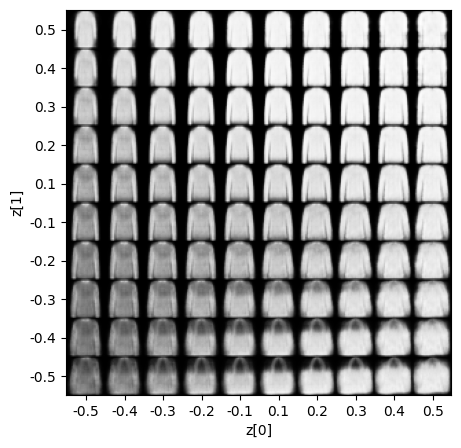

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
	# display a n*n 2D manifold of images
	img_size = 28
	scale = 0.5
	figure = np.zeros((img_size * n, img_size * n))
	# linearly spaced coordinates corresponding to the 2D plot
	# of images classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			sample = np.array([[xi, yi]])
			x_decoded = vae.decoder.predict(sample, verbose=0)
			images = x_decoded[0].reshape(img_size, img_size)
			figure[
				i * img_size : (i + 1) * img_size,
				j * img_size : (j + 1) * img_size,
			] = images

	plt.figure(figsize=(figsize, figsize))
	start_range = img_size // 2
	end_range = n * img_size + start_range
	pixel_range = np.arange(start_range, end_range, img_size)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap="Greys_r")
	plt.show()


plot_latent_space(vae)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step


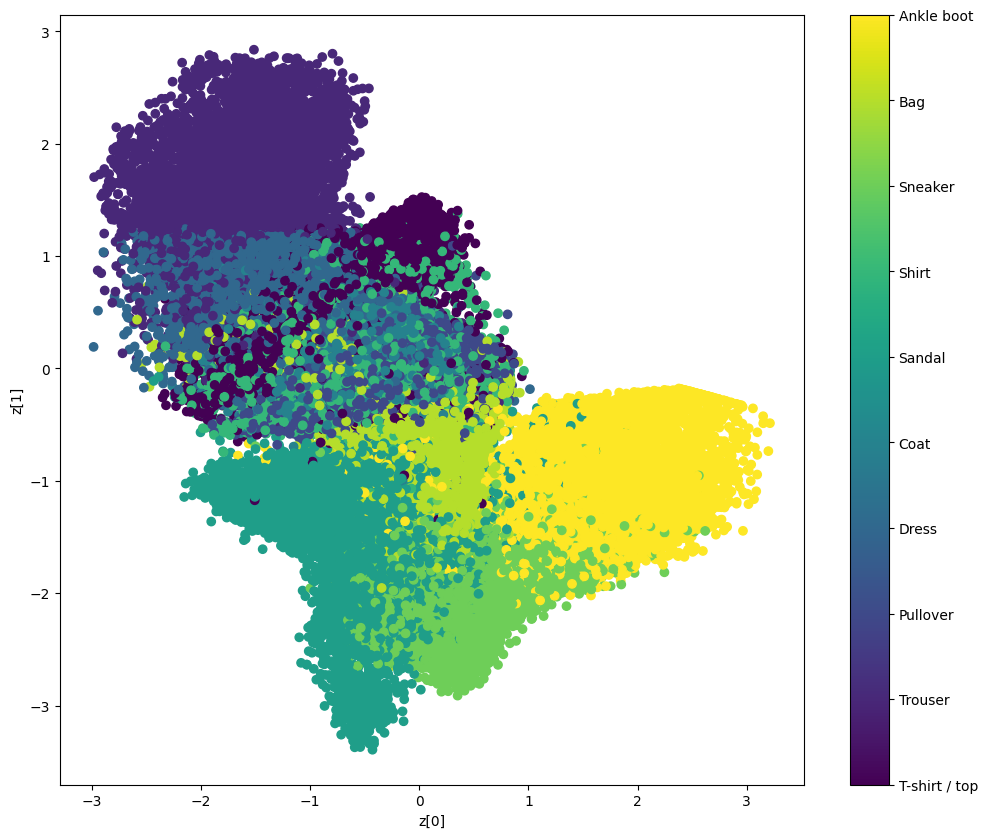

In [ ]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
